# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = True
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ['cat', 'dog']


In [3]:
print(type(trainset))

<class 'torchvision.datasets.cifar.CIFAR10'>


In [4]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 2

# Test data
Number of points: 2000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 2


In [5]:
print(type(testset))

<class 'torchvision.datasets.cifar.CIFAR10'>


Let us show some of the training images, for fun.



  dog   cat   cat   dog


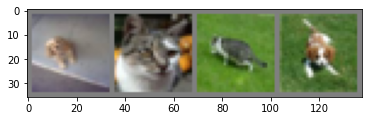

In [6]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture.

In [7]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 18, 
                               kernel_size = 5, 
                               stride = 1,
                               padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 18,   # must be the same as out_channels in the previous conv layer
                               out_channels = 16,
                               kernel_size = 5,
                               stride = 1,
                               padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.25)

        # fully connected output layers
        self.fc1 = nn.Linear(16 * 3 * 3 * 4, 84)
        self.fc2 = nn.Linear(84, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 3 * 3 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # note use of Functional.dropout, where training must be explicitly defined (default: False)
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x

net = CNN()
print(net)

CNN(
  (conv1): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(18, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
)


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [9]:
num_epoch = 10
net.cuda()

for epoch in range(num_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  1000] loss: 0.783
[1,  2000] loss: 0.691
[2,  1000] loss: 0.668
[2,  2000] loss: 0.659
[3,  1000] loss: 0.640
[3,  2000] loss: 0.636
[4,  1000] loss: 0.634
[4,  2000] loss: 0.622
[5,  1000] loss: 0.610
[5,  2000] loss: 0.618
[6,  1000] loss: 0.607
[6,  2000] loss: 0.614
[7,  1000] loss: 0.590
[7,  2000] loss: 0.613
[8,  1000] loss: 0.617
[8,  2000] loss: 0.620
[9,  1000] loss: 0.623
[9,  2000] loss: 0.602
[10,  1000] loss: 0.614
[10,  2000] loss: 0.623
Finished Training


## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

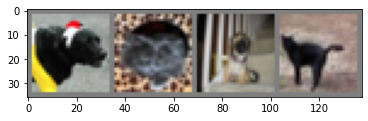

GroundTruth:     dog   cat   dog   cat
Predicted:       cat   dog   dog   cat


In [10]:
images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.cuda())
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [11]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.data.shape[0], 100 * correct.true_divide(total)))

Accuracy of the network on the 2000 test images: 64.00 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [12]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    labels = Variable(labels.cuda())
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of cat   : 55.00 %
Accuracy of dog   : 72.10 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer 1:**

> Initially I ran a simple CNN comprised of a single 2D convolution filter of kernel size = 5, followed by a 2x2 maxpool to diminish feature size. I used ReLU activation function in the fully connected layerss.

> I ran on the subsampled dataset (using only two classes: cats and dogs). The accuracy of cat was **87.80%** and **39.20%** for dog, which is pretty bad. The overall accuracy of the network on the 2000 test images was **63.50%**, which is above 60%. But we can do better.


```
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
```

**Answer 2:** 

> To improve the performance of the network I added a second convolution network followed by another maxpool. I also added dropout to the fully-connected section of the network in order to reduce overfitting. The network was slower to train and did not improve results at all. The overall accuracy of the network on the 2000 test images was **63.75%** (**89.40%** accuracy for cat and **38.50%** accuracy for dog). I am surprised that adding more layers (therefore complexity) did not improve performance. 

> Next I experimented with changing the parameters within the convolution layer one at a time and seeing how they effected the outcome. I had to be careful in adjusting the dimensions along the way.
- First, I increased the width of the net from 6 to 18. This did not improve overall accuracy, but it did even out the accuracy of each category so now cat and dog both had an accuracy of around 63%.
- Next, I thought that reducing kernel size would make the net more sensitive to small detailed changes within the images and therefore better able to distinguish between the different categories.
- I experimented with stride and padding. Adding a padding of 1 increased accuracy, but giving a stride of 2 decreased accuracy below 60% overall (although the accuracy for cat went up to 95.50%).
- I experimented with different kernel sizes (3 and 7) but a kernel size of 5 performed the best.
- Finally, after not getting an overall accuracy higher than **67.45%**, I decided to increase the number of epochs from 3 to 10. When I did this, the accuracy didn't improve, but actually dropped to 65%. This was very surprising.

The code that resulted in the highest overall accuracy is as follows:

```
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 18, 
                               kernel_size = 5, 
                               stride = 1,
                               padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 18,   # must be the same as out_channels in the previous conv layer
                               out_channels = 16,
                               kernel_size = 5,
                               stride = 1,
                               padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.25)

        # fully connected output layers
        self.fc1 = nn.Linear(16 * 3 * 3 * 4, 84)
        self.fc2 = nn.Linear(84, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 3 * 3 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # note use of Functional.dropout, where training must be explicitly defined (default: False)
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
```

**Answer 3:**

> After experimenting, I learned that increasing the number of convolution layer or the number of epochs will not make your model perform better. In fact, the opposite can be true. In the end, I am not really sure how to increase the performance of my model above 68%. I feel like I tested every parameter. I did learn that the ReLU activation function performed best compared to tanh and elu. Hopefully as the course progresses I will get a better feel in what and how to tweak a model to increase performance.


# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

> **ANSWER** I have added .cuda() to the code where necessary to send inputs and targets to the GPU. However, I did not initially notice a difference in the run speed on GPU.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

> **ANSWER** Initially I ran the model on GPU with a network width of 6. It took approximately **47 seconds** to train the model over 3 epochs. The overall accuracy of the network on the 2000 test images was **65.60%** (75.20% and 57.40% for cat and dog respectively). Increasing the width of the network by a factor of 10 (from 6 to 60) improved the accuracy of the model. After the change, the total accuracy of the network on the 2000 test images was **70.25%**, and the accuracies for cat and dog classification were 74.4% and 64.9% respectively. Although it still took approximately 47 seconds to train the model (for 3 epochs), I would say this is a speedup because we increased the number of channels (and therefore processing power required) tenfold and yet execution time was still approximately the same.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Setting up GPU in Colab

In Colab, you will get 12 hours of execution time but the session will be disconnected if you are idle for more than 60 minutes. It means that for every 12 hours Disk, RAM, CPU Cache and the Data that is on our allocated virtual machine will get erased.

To enable GPU hardware accelerator, just go to **Runtime -> Change runtime type -> Hardware accelerator -> GPU**

# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:**

Chapter 2: How the backpropagation algorithm works.

**Backpropagation with linear neurons**

Suppose we replace the usual non-linear $\sigma$ function with $\sigma(z)=z$ throughout the network. Rewrite the backpropagation algorithm for this case.

**Answer:**

To backpropagate, we need to calculate the cost, or output error, $\delta^l$. Equation BP1 in Michael Nielsen's book defines output error as:

$$
\begin{align}
\delta^{l}_{j} &= \frac{\delta C}{\delta z^{l}_{j}} \\
& = \frac{\delta C}{\delta a^{l}_{j}} \sigma'(z^{l}_{j}) \\
& = \sum_{k}  w^{(l+1)}_{kj} \delta^{(l+1)}_{k} \sigma'(z^{l}_{j}) \\
& = \sum_{k}  w^{(l+1)}_{kj} \delta^{(l+1)}_{k} h'(z^{l}_{j})
\end{align}
$$

Replacing the non-linear activation function $h(z) = \sigma(z)$ with a linear activation function $h(z) = z$, the activation function is now just the *identity* function for every layer $l$. Since $h'(z)=1$ for the identity function, then we can rewrite the backpropagation algorithm as:

$$
\begin{align}
\delta^{l}_{j} &= \frac{\delta C}{\delta z^{l}_{j}} \\
& = \frac{\delta C}{\delta a^{l}_{j}} \sigma'(z^{l}_{j}) \\
& = \frac{\delta C}{\delta a^{l}_{j}} * 1 \\
& = \sum_{k}  w^{(l+1)}_{kj} \delta^{(l+1)}_{k}
\end{align}
$$

